In [1]:
import pandas as pd
import re
import nltk
import gensim
import csv
import matplotlib.pyplot as  plt
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#Allow unverified https connections
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sagar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sagar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sagar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sagar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Text Processing
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
lemmatizer = WordNetLemmatizer()

#function for lemmatizer
def stem(token):
    ret = lemmatizer.lemmatize(token)
    return ret
    
#function for cleaning data
def process_tokens(tokens):
    ret = []
    for token in tokens:
        token = token.lower()
        # remove any value that are not alphabetical
        new_token = re.sub(r'[^a-zA-Z]+', '', token) 
        #stemming
        new_token = stem(new_token)
        # remove empty value and single character value        
        if  len(new_token) >= 2: 
            vowels=len([v for v in new_token if v in "aeiou"])
            if vowels > 0: # remove line that only contains consonants
                ret.append(new_token)
    #remove stop words
    stop_words = stopwords.words('english')
    ret = [x for x in ret if x not in stop_words]
    
    return ret

#read the file, tokenize and split to 2 three categories
file = open('C:\\Sagarika\\UIC\\Spring 22\\566- Text mining\\Project\\tripadvisor.csv',encoding="utf8")
csvreader = csv.reader(file)
next(csvreader, None)

#tokenize by sentence and process tokens
sentences = []
Ratings = []
Positive = []
Negative = []
FiveStar = []
FourStar = []
ThreeStar = []
TwoStar = []
OneStar = []



for row in csvreader:
    word_punct_token = WordPunctTokenizer().tokenize(row[0])
    tokens = process_tokens(word_punct_token)
    sentences.append(tokens)
    Rating = WordPunctTokenizer().tokenize(row[1]) #To get Rating 
    Ratings.append(Rating)
    strings = [str(integer) for integer in Rating] # To convert string to integer
    a_string = "".join(strings)
    a_rating = int(a_string)
    if a_rating>=3: # To Divide words into three categories[Positive, Negative]
        Positive.append(tokens)
    if a_rating<3:
        Negative.append(tokens)
    if a_rating==5:
        FiveStar.append(tokens)
    if a_rating==4:
        FourStar.append(tokens)
    if a_rating==3:
        ThreeStar.append(tokens)
    if a_rating==2:
        TwoStar.append(tokens)
    if a_rating==1:
        OneStar.append(tokens)

print('done')

c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


done


In [5]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Create Flat list 
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Full_flat_list = [item for sublist in sentences for item in sublist]

FiveStar_set = set([item for sublist in FiveStar for item in sublist])
FourStar_set = set([item for sublist in FourStar for item in sublist])
ThreeStar_set = set([item for sublist in ThreeStar for item in sublist])
TwoStar_set = set([item for sublist in TwoStar for item in sublist])
OneStar_set = set([item for sublist in OneStar for item in sublist])

common_words = set.intersection(FiveStar_set,FourStar_set,ThreeStar_set,TwoStar_set,OneStar_set) 


Negative_flat_list =[item for sublist in Negative for item in sublist if item not in common_words]
Positive_flat_list =[item for sublist in Positive for item in sublist]





c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


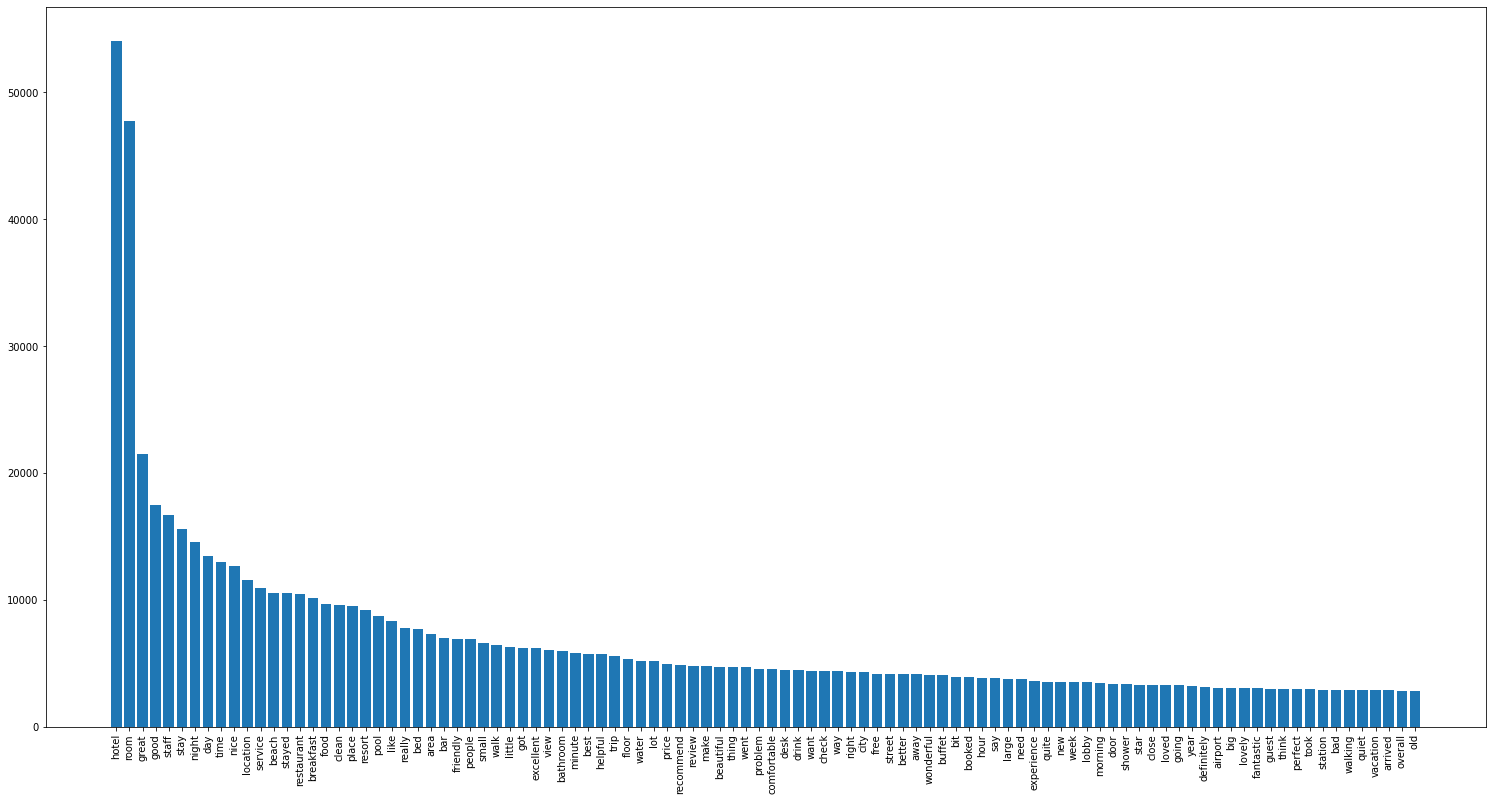

In [6]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Overall 100 most frequent words
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
tokenFreqDist = nltk.FreqDist(Full_flat_list)
topWords = tokenFreqDist.most_common(100)
x_val = [x[0] for x in topWords]
y_val = [x[1] for x in topWords]
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x_val,y_val)
plt.xticks(rotation=90)
plt.show()

c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


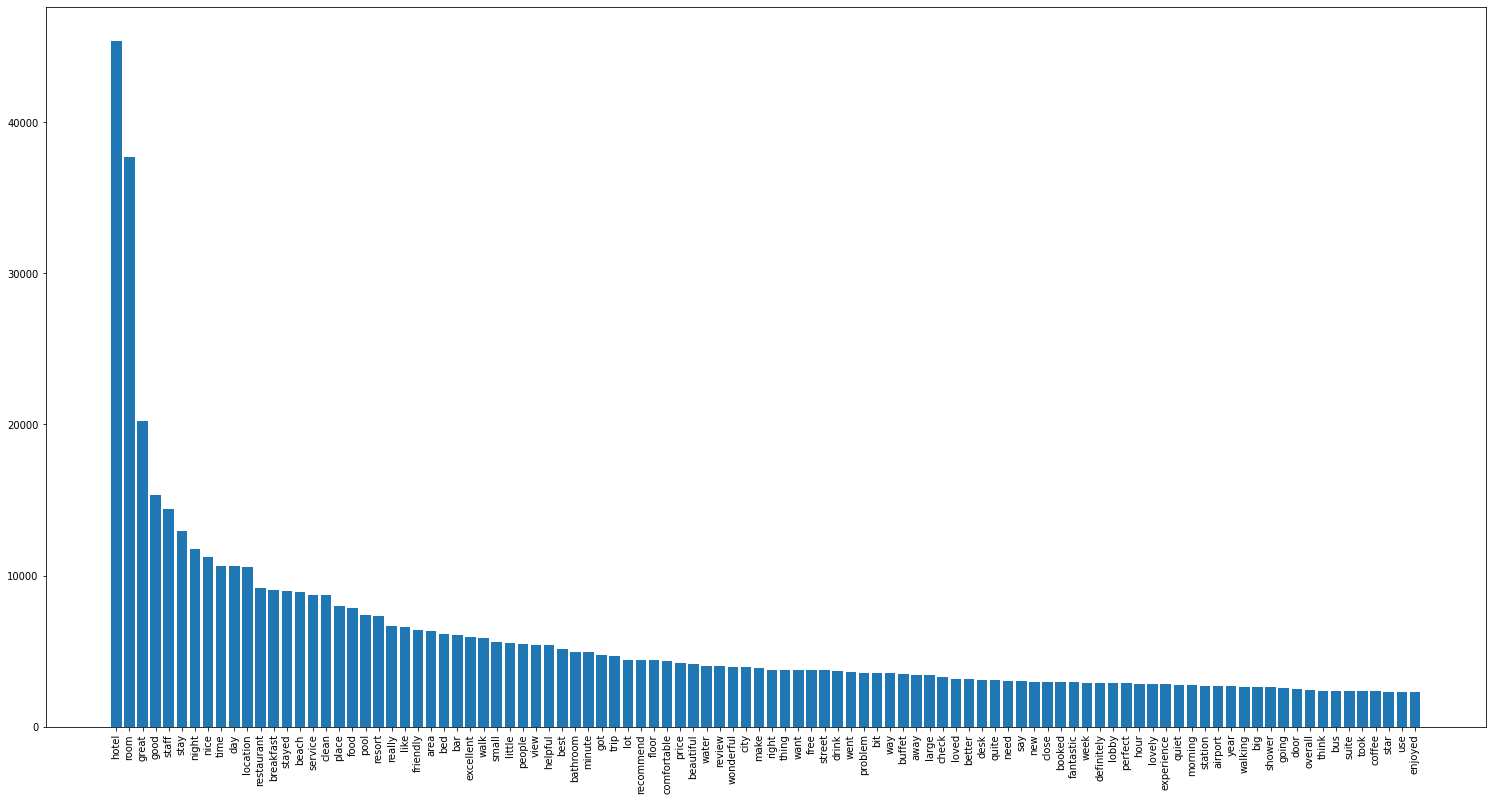

In [7]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Positive Reviews 100 most frequent words
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
tokenFreqDist = nltk.FreqDist(Positive_flat_list)
topWords = tokenFreqDist.most_common(100)
x_val = [x[0] for x in topWords]
y_val = [x[1] for x in topWords]
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x_val,y_val)
plt.xticks(rotation=90)
plt.show()

c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


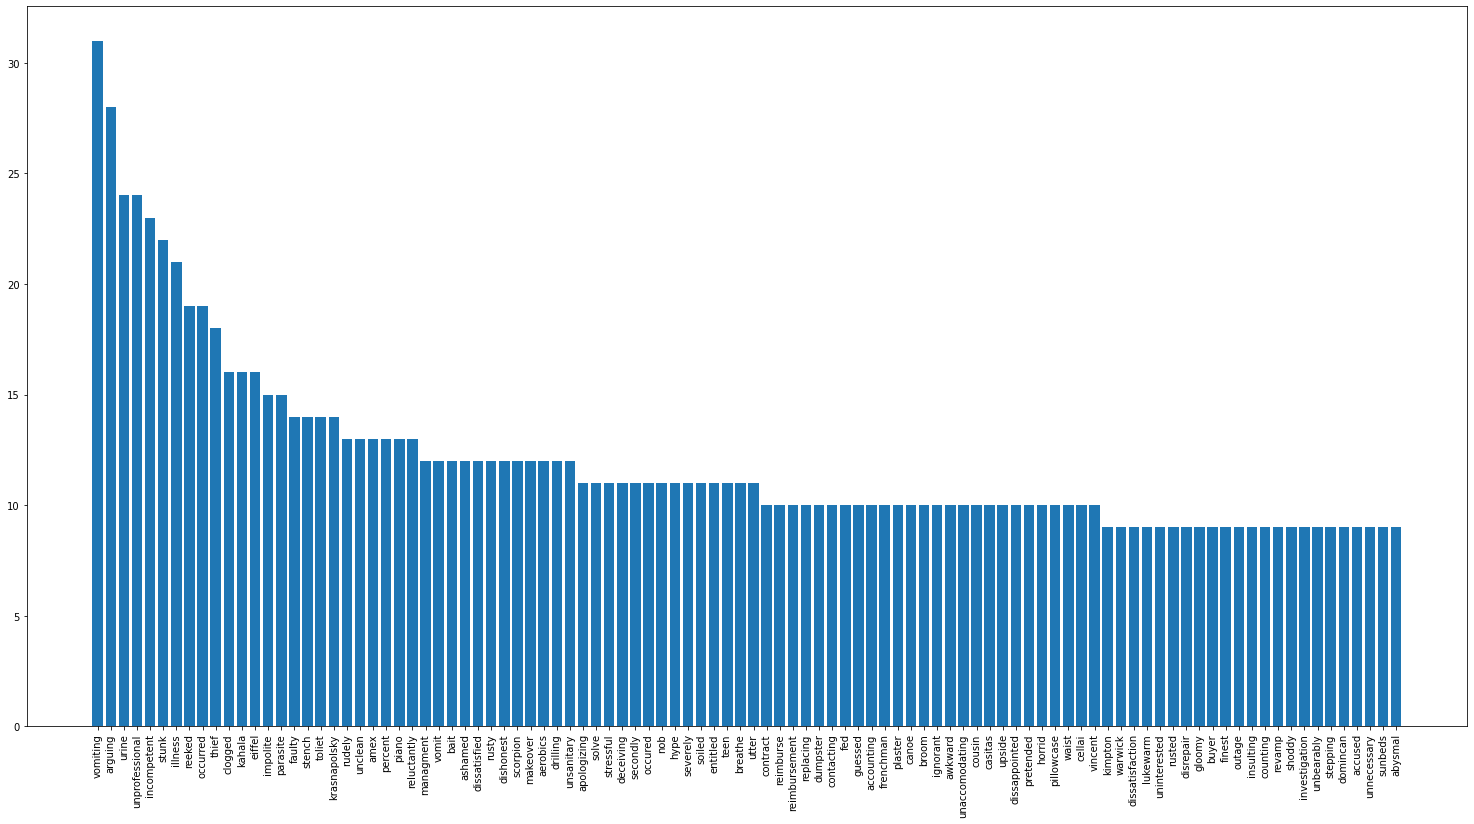

In [8]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Negative Reviews 100 most frequent words
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
tokenFreqDist = nltk.FreqDist(Negative_flat_list)
topWords = tokenFreqDist.most_common(100)
x_val = [x[0] for x in topWords]
y_val = [x[1] for x in topWords]
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x_val,y_val)
plt.xticks(rotation=90)
plt.show()

c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Rating count'}, ylabel='count'>

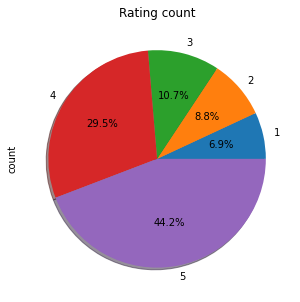

In [9]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Exploratory Data Analysis
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
df= pd.DataFrame(Ratings,columns=['Rating'])
counts= df.groupby('Rating').Rating.count().to_frame('count').reset_index()
counts.plot.pie(y='count',labels=counts['Rating'],figsize=(5,5),title="Rating count", legend=False,
                   autopct='%1.1f%%', 
                   shadow=True, startangle=0)

c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


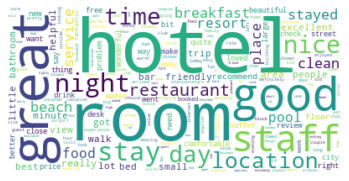

In [10]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Word cloud for Positive reviews
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Create and generate a word cloud image:
PositiveSentence = ' '.join(Positive_flat_list)
NegativeSentence = ' '.join(Negative_flat_list)
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(PositiveSentence)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

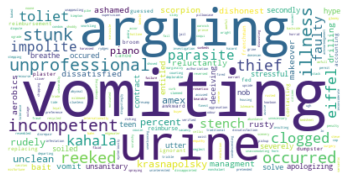

In [ ]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Word cloud for Negative reviews
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(NegativeSentence)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [14]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       LDA Topic Modeling
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
id2word = corpora.Dictionary(sentences)
corpus = []
for text in sentences:
    new = id2word.doc2bow(text)
    corpus.append(new)
    
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, random_state=100,update_every=1,chunksize=100, passes=10, iterations=50,alpha="auto")

#Visualize the LDA model
vis = pyLDAvis.gensim_models.prepare(ldamodel,corpus,id2word,mds="mmds",R=10)
vis

c:\users\sagar\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.043483  0.177263       1        1  43.102685
2      0.186736 -0.043868       2        1  32.621933
0     -0.143253 -0.133395       3        1  24.275382, topic_info=        Term          Freq         Total Category  logprob  loglift
29     hotel  53950.000000  53950.000000  Default  10.0000  10.0000
55      room  47537.000000  47537.000000  Default   9.0000   9.0000
5128   beach   9984.000000   9984.000000  Default   8.0000   8.0000
5070  resort   8447.000000   8447.000000  Default   7.0000   7.0000
1110    pool   9352.000000   9352.000000  Default   6.0000   6.0000
...      ...           ...           ...      ...      ...      ...
109      day   5287.807295  13961.958150   Topic3  -4.5130   0.4448
49    people   3701.003209   6769.789156   Topic3  -4.8698   0.8118
24     great   5626.554085  21752.665235   Topic3  -4.4509   0.0635
22      good   5121.995699  17335.719701   Topic3  -4.5448   0.1965
917      bar   3801.259472   8069.051679   Topic3  -4.8431   0.6630

[87 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
365       3  0.998892  activity
3         1  0.149041   arrived
3         2  0.817694   arrived
3         3  0.033285   arrived
75        2  0.999847     asked
...     ...       ...       ...
649       1  0.999610     value
6673      1  0.000627     villa
6673      3  0.999362     villa
448       1  0.880160      walk
448       3  0.119772      walk

[131 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=sentences, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.658074629286276

Coherence Score:  0.37772993863474574


In [ ]:
Review=[]
for review in sentences:
    temp=''
    for s in review:
        temp+=s+" "
    Review.append(temp)
Reviewdf = pd.DataFrame(Review,columns=['Text'])

#Creating LDA features for Logistic Regression
train_vecs = []
for i in range(len(Reviewdf)):
    top_topics = (
        ldamodel.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(5)]
    topic_vec.extend([len(Reviewdf)])
    topic_vec.extend([len(Reviewdf.Text[i])])
    train_vecs.append(topic_vec)

Ratingsdf= pd.DataFrame(Ratings,columns=['Rating'])
def getRatingAnalysis(score):
    if int(score)<=3:
        return 'Negative'
    else:
        return 'Positive'
Ratingsdf['Actual'] = Ratingsdf['Rating'].apply(getRatingAnalysis)
train_vecs = pd.DataFrame(train_vecs,columns=['Feature1','Feature2','Feature3','Feature4','Feature5','Total count' ,'Text count'])
LDAFeatures = pd.concat([train_vecs, Ratingsdf], axis=1)
LDAFeatures = LDAFeatures.drop('Total count', axis=1)
LDAFeatures = LDAFeatures.drop('Text count', axis=1)
LDAFeatures = LDAFeatures.drop('Rating', axis=1)
LDAFeatures['Actual'][LDAFeatures['Actual']== 'Positive'] = 1
LDAFeatures['Actual'][LDAFeatures['Actual']== 'Negative'] = 0
X = LDAFeatures.iloc[: , :5]
y = LDAFeatures.iloc[:,-1]
y = pd.DataFrame(y,columns=['Actual'])
y=y.astype('int')

/var/folders/gz/zjx53sjj65d9pjnq5b312zsm0000gn/T/ipykernel_21443/3332457206.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LDAFeatures['Actual'][LDAFeatures['Actual']== 'Positive'] = 1
/var/folders/gz/zjx53sjj65d9pjnq5b312zsm0000gn/T/ipykernel_21443/3332457206.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LDAFeatures['Actual'][LDAFeatures['Actual']== 'Negative'] = 0


In [ ]:
#Split Test and Train data for Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

#Fitting the model 
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test) #Predicting 

# import the metrics class for Logistic Regression
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8497072218607677
Precision: 0.8677074774034511
Recall: 0.9378330373001776


/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                       Sentiment Analysis using TextBlob
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#function for subjectivity
def getSubjectivity(Reviewdf):
    return TextBlob(Reviewdf).sentiment.subjectivity

#function for polarity
def getPolarity(Reviewdf):
    return TextBlob(Reviewdf).sentiment.polarity

#create new columns
Reviewdf['Subjectivity'] = Reviewdf['Text'].apply(getSubjectivity)
Reviewdf['Polarity'] =Reviewdf['Text'].apply(getPolarity)

#Function to compute positive and negative analysis
def getAnalysis(score):
    if score<=0:
        return 'Negative'
    else:
        return 'Positive'
Reviewdf['Analysis'] = Reviewdf['Polarity'].apply(getAnalysis)
Reviewdf

,Text,Subjectivity,Polarity,Analysis
0,nice hotel expensive parking got good deal sta...,0.687000,0.208744,Positive
1,ok nothing special charge diamond member hilto...,0.516630,0.246004,Positive
2,nice room experience hotel monaco seattle good...,0.606239,0.266138,Positive
3,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive
4,great stay great stay went seahawk game awesom...,0.627296,0.469643,Positive
...,...,...,...,...
20486,best kept secret time staying charm star ca be...,0.526768,0.209229,Positive
20487,great location price view hotel great quick pl...,0.600000,0.463333,Positive
20488,ok look nice modern outside desk staff particu...,0.524304,0.171220,Positive
20489,hotel theft ruined vacation hotel opened sept ...,0.532371,0.145881,Positive


In [ ]:
#Percentage of positive reviews
posreview= Reviewdf[Reviewdf['Analysis'] == 'Positive']
posreview = posreview['Text']
round ((posreview.shape[0]/Reviewdf.shape[0])*100,1)

94.3

In [ ]:
#Percentage of Negative reviews
Negreview= Reviewdf[Reviewdf['Analysis'] == 'Negative']
Negreview = Negreview['Text']
round ((Negreview.shape[0]/Reviewdf.shape[0])*100,1)

5.7

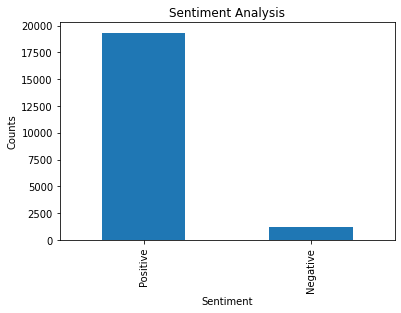

In [ ]:
#Bar Plot to show the Sentiment analysis based on review count
Reviewdf['Analysis'].value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
Reviewdf['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
#Calculate Accuracy using TextBlob
Reviewdf = pd.concat([Reviewdf, Ratingsdf], axis=1)

Accuracy = len(Reviewdf[Reviewdf['Analysis']==Reviewdf['Actual']])/len(Reviewdf)
Accuracy

0.7884925089063491

In [ ]:
#@title Setup & Config
import transformers as ppb
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from sklearn.linear_model import LogisticRegression

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
df = pd.read_csv('tripadvisor.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.loc[df['Rating'] > 3 , 'label'] = 1
df.loc[df['Rating']<= 3, 'label'] = 0
df['label'].astype(int)
df = df.drop(columns= 'Rating')
batch_1 = df[:500]
batch_1['label'].value_counts()

1.0    299
0.0    201
Name: label, dtype: int64

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

/Users/thanhpham/Library/Python/3.10/lib/python/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initial

In [ ]:
tokenized = batch_1['Review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation= True, max_length= 250, padding=True)))


In [ ]:
#Padding: we need to pad all lists to the same size
max_len = 250
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
input_ids = torch.tensor(np.array(padded))
input_ids.shape


torch.Size([500, 250])

In [ ]:
#Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask = torch.tensor(attention_mask)
attention_mask.shape

torch.Size([500, 250])

In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask, return_dict=False)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = batch_1['label']

In [ ]:
features.shape

(500, 768)

In [ ]:
labels.shape

(500,)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
lr_clf.score(test_features, test_labels)

0.84